IN PROGRESS
========
* RETRAINING USING A BALANCED SET.  For each annotator, compute precent correct for each preposition.  Compare to model performance.
 * If ranking of preposition difficulty for humans differs from that of the model, include correlation of F1 and train N in paper as a possible explanation for the difference.
 * If ranking of preposition difficulty for humans differs from that of the model, downsample the overrepresented classes in the training set so it's balanced, and retrain.  I'm not sure this would change the results, but that's OK.  The submission deadline is in January, it only takes a week to train the model, and the analysis is repeatable, so completing this task essentially only requires (1) the initial downsampling and (2) the opportunity cost of *not* being able to train some other model at the same time.
 * Create a task-specific notebook just for running the sensitivity analysis.  This must run on a machine with a GPU.
* Re-run the feature evaluation models using balanced data.
 * Use a much lower capacity model and 1m sentences for training.
 * Do cross-validation over filter_width [2, 3, 4, 5], n_filters [10, 100, 1000], and feature sets [X], [Xwindow?] (for ? in 5,7,9), [Xwindow?NULL] (for ? in 5,7,9), [Xwindow? X] (for ? in 5,7,9), and [Xwindow?NULL X] (for ? in 5,7,9).

TODO
-------------
* Re-start the LSTM model with balanced data (later).
* Train a convolutional model using just the window (without replacing the preposition with the nonce).  Save the weights of the model every epoch.  Plot, over epochs, 
 * The number of principal components necessary to explain 95% of the variance (it should increase over time).
 * Box plots of all-pairs cosine similarity (they should decrease over time).
* Paper:
 * Add table of examples showing where humans disagree with the corpus (but the model agrees with the corpus), where the model disagrees with the corpus (but the human agrees with the corpus), and where the model and the human agree with one another (and they both disagree with the corpus).
 * Send first draft to Peter, Mark, Kyle, and Lakshmi.
 * Send first revision to Jim and Martha.
 * Send third revision to Jordan.
* Human annotations
 * Report inter-rater reliability as a matrix of Cohen's Kappa.
 * Show examples where humans disagree with corpus.

DONE
-----------
* Add verbose=False option to modeling.utils.load_model.
* Make script to read HDF5 file of data, get predictions and probabilities for the data from some model, add the predictions and probabilities to the in-memory HDF5 file, and write the HDF5 file to disc somewhere new.
* Write function to merge human judgements into a single data frame:
 * Make a separate data frame of sent_id, sentence.
 * Make the corpus an annotator of its own.
 * Make the model an annotator of its own.
 * One row per judgment (sent_id, annotator_id, ...).
 * Improving detection and correction (Will not do.  Precision-recall curves are sufficient).
   * Write functions to filter out sentences based on different criteria:
   * Sentence length
   * Number of unknown words
   * Whether the probability of the most probable class exceeds some threshold
* Week of November 16:
 * Friday
   * Change annotator confidence histograms so bars are the same height across the x axis.
* Week of 23:
  * Monday
   * Modify this notebook to load the HDF5 files containing probabilities/predictions.  I should be able to run the analysis in this notebook on a machine that doesn't have a GPU (e.g. my laptop).
   * Change `load_predict_save` to put predictions and probabilities in separate file named DATA_FILE-MODEL_UUID.h5 and the model configuration in a file named DATA_FILE-MODEL_UUID.json.
   * Change the train, validation, and test sets to be balanced.  Start retraining a convnet using the balanced data.
   * Add option to train_keras.py to ignore the weights in the target-data.json file so as to avoid bias when training with the balanced version of the data.
  * Tuesday
   * Write function and tests to add a window of k words (with and without nonce) to an .h5 file.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Use Times New Roman for NAACL. 
font = {'family' : 'serif',
        'serif': 'Times New Roman',
        'size'   : 12,
       }
plt.rc('font', **font)

text = {
        'latex.unicode': True,
        'latex.preamble': r"\usepackage{times}"
        }
plt.rc('text', **text)

In [2]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
import itertools

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(
            itertools.combinations(s, r) for r in range(len(s)+1))

linestyle = itertools.cycle(['-', '--', '-.', ':'])

In [4]:
import shutil
import os
import json
import h5py

import pandas as pd

from sklearn.metrics import (confusion_matrix,
        fbeta_score, cohen_kappa_score,
        precision_recall_fscore_support, precision_recall_curve)
from sklearn.dummy import DummyClassifier

import modeling.utils

In [5]:
# For scikit learn metrics.
weighting = 'macro'

In [6]:
# model_dir = 'models/keras/preposition/convnet/4e0ae5dc683611e5950afcaa149e39ea'
# model_dir = 'models/keras/preposition/convnet/7a87f8e870f111e5950afcaa149e39ea'
# model_dir = 'models/keras/preposition/convnet/6cd818a886af11e59052fcaa149e39ea/'

# Accidentally terminated, but it was progressing nicely.
#model_dir = 'models/keras/preposition/convnet/7040fefc88c011e5b2b374d435ed6f3a/'

# Best so far, but imbalanced.
# model_dir = 'models/keras/preposition/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/'

# Balanced.
# model_dir = 'models/keras/preposition/convnet/balanced/'

# Load the test set for evaluation.
# data_file = 'data/preposition/prepositions-all-new-test.h5'

In [7]:
# To generate the data file used by this notebook, run the following on a machine with a GPU.
# Set the model directory.
#model_dir = 'models/keras/prepositions/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/'
# Set the data file.
# data_file = 'data/preposition/prepositions-all-new-test.h5'
# Load the model, get predictions, and save output.
#modeling.utils.load_predict_save(model_dir, data_file)
# model, model_cfg = modeling.utils.load_model(model_dir, load_weights=True)

In [8]:
model_id = '20a7a6b088ee11e5b2b374d435ed6f3a'
basename = 'data/preposition/prepositions-all-new'
qualifier = '-test'

In [9]:
# Load model predictions and softmax probabilities.
pred_file = basename + qualifier + '-' + model_id + '-pred.h5'
f = h5py.File(pred_file, 'r')
preds = f['pred'].value
probs = f['prob'].value
f.close()

In [10]:
# Load model configuration (i.e. hyperparameters and other settings).
model_json_file = basename + qualifier + '-' + model_id + '-cfg.json'
model_json = json.load(open(model_json_file))
model_cfg = modeling.utils.ModelConfig(**model_json)

In [11]:
# Load target data or metadata (e.g. mapping between numeric target variable and preposition).
target_data_file = basename + '-target-data.json'
target_data = json.load(open(target_data_file))

In [12]:
# Load targets (multiclass, binary), examples (e.g. windows around a preposition, the entire sentence),
# and other data about the inputs (e.g. the length of each sentence).
data_file = basename + qualifier + '.h5'
model_data = modeling.utils.load_all_model_data(data_file, model_cfg)

[(999552, 5), (999552, 52)]


In [13]:
evens = np.arange(0, len(preds), 2)
odds = evens + 1

In [14]:
dummy_prior = DummyClassifier(strategy='prior', random_state=17)
dummy_prior.fit(model_data.data, model_data.target)
preds_prior = dummy_prior.predict(model_data.data)
probs_prior = dummy_prior.predict_proba(model_data.data)

dummy_uniform = DummyClassifier(strategy='uniform', random_state=17)
dummy_uniform.fit(model_data.data, model_data.target)
preds_uniform = dummy_uniform.predict(model_data.data)
probs_uniform = dummy_uniform.predict_proba(model_data.data)

Error judgments from annotators
=======

In [15]:
annotator_data_dir = os.environ['HOME'] + '/proj/dissertation/projects/cnn/data/preposition/annotations/'
annotator1_csv = annotator_data_dir + 'annotator01-results.csv'
annotator2_csv = annotator_data_dir + 'annotator02-results.csv'
annotator3_csv = annotator_data_dir + 'annotator03-results.csv'
annotator4_csv = annotator_data_dir + 'annotator04-results.csv'

corpus_annotator_id = 5
model_annotator_id = 6

def normalize_annotator_columns(annotator_df):
    """
    Rename columns of a data frame of annotator judgements.
    
    Parameters
    ----------
    annotator_df: pandas.DataFrame
        A data frame of annotator judgements.
    
    Returns
    ----------
    new_df: pandas.DataFrame
        A data frame containing the same data with columns renamed as follows:
          'Sentence id'         => 'sent_id'
          'Sentence'            => 'sentence'
          'Correct Preposition' => 'correct_preposition'
          'Confidence'          => 'confidence'
          'Sentence Quality'    => 'sent_quality'
    """
    rename_columns = {
            'Sentence id': 'sent_id',
            'Sentence': 'sentence',
            'Correct Preposition': 'correct_preposition',
            'Confidence': 'confidence',
            'Sentence Quality': 'sent_quality'
            }
    
    new_df = annotator_df.copy()
    
    for (old_column, new_column) in rename_columns.items():
        new_df[new_column] = new_df[old_column]
        del new_df[old_column]
        
    return new_df

def load_annotator_df(annotator_csv):
    """
    Load a data frame of annotator judgments.
    
    Parameters
    ----------
    annotator_csv : str
        Path to a .csv file containing annotator judgments.
    
    Returns
    -----------
    df : pandas.DataFrame
        A data frame of annotator judgments with normalized column names.
    """
    annotator_df = pd.read_csv(annotator_csv, sep='\t')
    annotator_df = normalize_annotator_columns(annotator_df.ix[:, 0:5])
    return annotator_df.sort('sent_id')

def sent_is_modified(sent_ids):
    return sent_ids > 30600000

def get_model_data_indices(annotator_df):
    """
    Because of how I sampled the sentences for the humans to annotate, the sentences
    in the annotator's data set with IDs < 30600000 are (presumably) error free, and
    those with IDs > 30600000 contain a preposition error.  For each sentence ID in
    the annotator's data set, I need to find the indices of the two positions in the
    test set used by the model, and select the first of the two indices (the one at
    an even-numbered index) if the sentence ID < 30600000 and use select the second
    of the two if the sentence ID > 30600000.
    
    Parameters
    --------
    annotator_df : pandas.DataFrame
        A data frame of annotator judgments.
        
    Returns
    ---------
    sent_id : list
        A list of indices for subscripting data loaded using `load_all_model_data`.
    """
    sent_ids = annotator_df['sent_id'].values
    annotator_evens = set(sent_ids[~sent_is_modified(sent_ids)])
    annotator_odds = set(sent_ids[sent_is_modified(sent_ids)])
    
    sent_idx = []

    for idx,sent_id in enumerate(model_data.sent_id):
        if idx % 2 == 0:
            if sent_id in annotator_evens:
                sent_idx.append(idx)
        elif sent_id in annotator_odds:
            sent_idx.append(idx)
            
    return sent_idx

def build_annotator(annotator_csv, target_data, annotator_id):
    df = load_annotator_df(annotator_csv)
    df['correct_preposition_code'] = [target_data['original_word_code']['names'].index(word)
                                 for word in df['correct_preposition']]
    df['annotator_id'] = annotator_id
    df['probability'] = None
    return df

def build_corpus_annotator(annotator_df, target_data, model_data, annotator_id=corpus_annotator_id):
    sent_idx = get_model_data_indices(annotator_df)
    sent_ids = sorted(np.unique(annotator_df.sent_id))
    
    df = pd.DataFrame({
            'sent_id': sent_ids,
            'annotator_id': [annotator_id] * len(sent_idx),
            'correct_preposition_code': model_data.target[sent_idx],
            'correct_preposition': [target_data['original_word_code']['names'][word]
                            for word in model_data.target[sent_idx]],
            'confidence': [None] * len(sent_idx),
            'sent_quality': [None] * len(sent_idx),
            'probability': [None] * len(sent_idx)
            })
    
    #print('corpus annotator', df.shape)
    
    return df
    
def build_model_annotator(annotator_df, target_data, preds, probs, annotator_id=model_annotator_id):
    sent_idx = get_model_data_indices(annotator_df)
    sent_ids = sorted(np.unique(annotator_df.sent_id))
    
    df = pd.DataFrame({
            'sent_id': sent_ids,
            'annotator_id': [annotator_id] * len(sent_ids),
            'correct_preposition_code': preds[sent_idx],
            'correct_preposition': [target_data['original_word_code']['names'][word]
                        for word in preds[sent_idx]],
            'confidence': [None] * len(sent_idx),
            'sent_quality': [None] * len(sent_idx),
            'probability': np.max(probs[sent_idx], axis=1)
        })
    
    #print('model annotator', df.shape)
                      
    return df

def build_kappa_comparator(column='correct_preposition'):
    def compute_kappa(df1, df2):
        return cohen_kappa_score(df1[column], df2[column])
    return compute_kappa

def build_annotators_df():
    annotator1_df = build_annotator(annotator1_csv, target_data, annotator_id=1)
    annotator2_df = build_annotator(annotator2_csv, target_data, annotator_id=2)
    annotator3_df = build_annotator(annotator3_csv, target_data, annotator_id=3)
    annotator4_df = build_annotator(annotator4_csv, target_data, annotator_id=4)
    
    annotator_df = pd.concat([annotator1_df, annotator2_df, annotator3_df, annotator4_df])
    sent_df = annotator_df[['sent_id', 'sentence']]
    del annotator_df['sentence']
    columns = sorted(annotator_df.columns)
    annotator_df = annotator_df[columns]

    corpus_df = build_corpus_annotator(annotator_df, target_data, model_data)[columns]
    model_df = build_model_annotator(annotator_df, target_data, preds, probs)[columns]

    df = pd.concat([annotator_df, corpus_df, model_df])
    df.sort('sent_id', inplace=True)
    
    sent_df.drop_duplicates(subset=['sent_id'], inplace=True)
    sent_df.sort('sent_id', inplace=True)
    
    return df, sent_df

In [66]:
annotator_names = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    corpus_annotator_id: 'corpus',
    model_annotator_id: 'model'
}

def compare_annotators(df, id1, id2, comparator):
    df1 = df[df.annotator_id == id1]
    df2 = df[df.annotator_id == id2]
    df2 = df2[df2.sent_id.isin(df1.sent_id)]
    df1 = df1[df1.sent_id.isin(df2.sent_id)]
    return comparator(df1, df2), len(df1)
    
def compute_annotator_kappas():
    df, _ = build_annotators_df()
    
    annotator1 = []
    annotator2 = []
    values = []
    ns = []
    kns = []
    
    comparator = build_kappa_comparator()
    pairs = itertools.combinations(annotator_names.keys(), 2)
    
    for pair in pairs:
        kappa, n = compare_annotators(df, pair[0], pair[1], comparator)
        names = [annotator_names[i] for i in pair]
        annotator1.extend(names)
        annotator2.extend(reversed(names))
        values.extend([kappa, kappa])
        ns.extend([n, n])
        kn = '{kappa:.2f} ({n})'.format(kappa=kappa, n=n)
        kns.extend([kn, kn])
        
    df_kappa = pd.DataFrame({
            'annotator 1': annotator1,
            'annotator 2': annotator2,
            'kappa': values,
            'n': ns,
            'kappan': kns
            })
    
    return df_kappa
    
df_kappa = compute_annotator_kappas()

df_kappa_pivot = df_kappa.pivot(index='annotator 1', columns='annotator 2', values='kappan')
np.fill_diagonal(df_kappa_pivot.values, '.')

print(df_kappa_pivot)
print('')
print(df_kappa_pivot.to_latex(float_format=lambda f: '%.02f' % f))

annotator 2           1           2           3           4       corpus  \
annotator 1                                                                
1                     .  0.83 (177)  0.72 (155)  0.70 (175)   0.78 (507)   
2            0.83 (177)           .  0.79 (163)  0.79 (179)   0.83 (519)   
3            0.72 (155)  0.79 (163)           .  0.77 (151)   0.80 (469)   
4            0.70 (175)  0.79 (179)  0.77 (151)           .   0.79 (505)   
corpus       0.78 (507)  0.83 (519)  0.80 (469)  0.79 (505)            .   
model        0.75 (507)  0.78 (519)  0.76 (469)  0.75 (505)  0.83 (1000)   

annotator 2        model  
annotator 1               
1             0.75 (507)  
2             0.78 (519)  
3             0.76 (469)  
4             0.75 (505)  
corpus       0.83 (1000)  
model                  .  

\begin{tabular}{lllllll}
\toprule
annotator 2 &           1 &           2 &           3 &           4 &       corpus &        model \\
\midrule
annotator 1 &             &   

In [17]:
def precision_recall_per_annotator():
    df, _ = build_annotators_df()
    
    precision = []
    recall = []
    f1 = []
    support = []
    preposition = []
    annotator = []
    
    for annotator_id in [1, 2, 3, 4, model_annotator_id]:
        # Get a data frame for just this annotator.
        annotator_df = df[df.annotator_id == annotator_id]
        
        # Get a data frame for the corpus itself.
        corpus_df = df[df.annotator_id == corpus_annotator_id].copy()
        
        # Retain only those rows in the corpus data frame for which the
        # given annotator provided a judgment.
        corpus_df = corpus_df[corpus_df.sent_id.isin(annotator_df.sent_id)]

        # Sort both data frames.
        annotator_df.sort('sent_id', inplace=True)
        corpus_df.sort('sent_id', inplace=True)
        
        p, r, f, s = precision_recall_fscore_support(
                corpus_df.correct_preposition,
                annotator_df.correct_preposition)
        
        precision.extend(p)
        recall.extend(r)
        f1.extend(f)
        support.extend(s)
        annotator.extend([annotator_id] * len(s))
        preposition.extend(target_data['original_word_code']['names'])
        
    return pd.DataFrame({
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'N': support,
            'Preposition': preposition,
            'Annotator': annotator
        })

def metric_rank_correlation(df, annotator1_id, annotator2_id, metric):
    import scipy.stats
    df = df.sort(['Annotator', 'Preposition'])
    return scipy.stats.spearmanr(
        df[df.Annotator == annotator1_id][metric],
        df[df.Annotator == annotator2_id][metric])

def annotator_metric_rank_correlation(pr_per_annotator_df, metric='F1'):
    df = pr_per_annotator_df.copy()
    df.sort(['Annotator', 'Preposition'], inplace=True)
    pairs = itertools.combinations(df.Annotator.unique(), 2)
    
    ranks = []
    ps = []
    annotator1 = []
    annotator2 = []
    
    for pair in pairs:
        rank, p = metric_rank_correlation(df, pair[0], pair[1], metric=metric)
        ranks.extend([rank, rank])
        ps.extend([p, p])
        names = [annotator_names[i] for i in pair]
        annotator1.extend(names)
        annotator2.extend(reversed(names))
        
    return pd.DataFrame({
            'Rank': ranks,
            'P': ps,
            'Annotator 1': annotator1,
            'Annotator 2': annotator2
            
        })

pr_per_annotator_df = precision_recall_per_annotator()
pr_per_annotator_df = pr_per_annotator_df.sort(['Annotator', 'F1'])[['Annotator', 'N', 'Preposition', 'F1', 'Precision', 'Recall']]
#pr_per_annotator_df

/Users/ndronen/miniconda/lib/python2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


In [18]:
def plot_annotator_f1_vs_model(pr_per_annotator_df):
    df = pr_per_annotator_df.sort('Preposition')
    
    df_model = pr_per_annotator_df[df.Annotator == model_annotator_id]
    df_model.sort('Preposition')
    
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '*']
    plt.figure(figsize=(9,6))
    
    for i, annotator_id in enumerate([1, 2, 3]):
        df_annotator = pr_per_annotator_df[df.Annotator == annotator_id]
        df_annotator = df_annotator.sort('Preposition')
        plt.scatter(df_model.F1, df_annotator.F1,
                    label=str(annotator_id), c=colors[i],
                    marker=markers[i], s=60)
                    # linewidth=2)
    plt.xlabel('Model F1')
    plt.ylabel('Annotator F1')
    plt.xlim(0.71, 1)
    plt.ylim(0.71, 1)
    plt.legend(loc='lower right')
    
#plot_annotator_f1_vs_model(pr_per_annotator_df)

In [19]:
f1_rank_cor_df = annotator_metric_rank_correlation(pr_per_annotator_df, metric='F1')
f1_rank_cor_df[f1_rank_cor_df['Annotator 2'] == annotator_names[model_annotator_id]]

,Annotator 1,Annotator 2,P,Rank
6,1,model,0.224216,0.450000
12,2,model,0.035770,0.700000
16,3,model,0.029818,0.716667
18,4,model,0.076929,0.616667


In [20]:
precision_rank_cor_df = annotator_metric_rank_correlation(pr_per_annotator_df, metric='Precision')
precision_rank_cor_df[precision_rank_cor_df['Annotator 2'] == annotator_names[model_annotator_id]]

,Annotator 1,Annotator 2,P,Rank
6,1,model,0.187470,0.483333
12,2,model,0.058073,0.650000
16,3,model,0.765008,0.116667
18,4,model,0.732368,0.133333


In [21]:
recall_rank_cor_df = annotator_metric_rank_correlation(pr_per_annotator_df, metric='Recall')
recall_rank_cor_df[recall_rank_cor_df['Annotator 2'] == annotator_names[model_annotator_id]]

,Annotator 1,Annotator 2,P,Rank
6,1,model,0.170471,0.500000
12,2,model,0.124977,0.550000
16,3,model,0.007225,0.816667
18,4,model,0.015944,0.766667


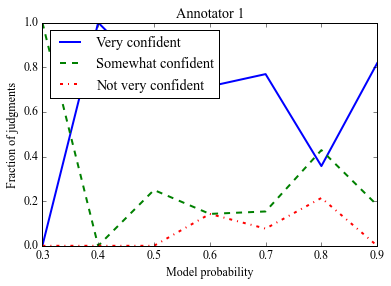

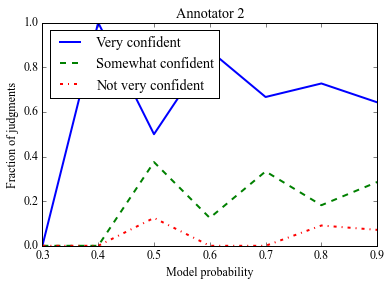

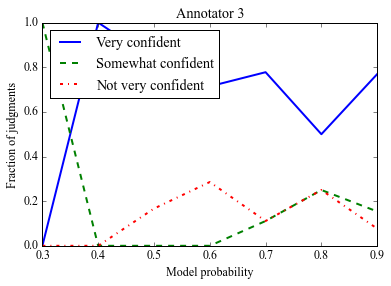

In [22]:
def plot_model_probabilities_conditioned_on_annotator_confidence():
    from collections import defaultdict
    
    df, _ = build_annotators_df()
    bins = np.linspace(0, 1, 9)
    
    conf_levels = df.confidence[df['confidence'].notnull()].unique()
    
    linestyles = [next(linestyle) for c in conf_levels]
    
    for annotator_id in [1, 2, 3]:
        # Get a data frame for just this annotator.
        annotator_df = df[df.annotator_id == annotator_id]
        
        # Get a data frame for the model itself.
        model_df = df[df.annotator_id == model_annotator_id].copy()
        
        # Retain only those rows in the model data frame for which the
        # given annotator provided a judgment.
        model_df = model_df[model_df.sent_id.isin(annotator_df.sent_id)]

        # Sort both data frames.
        annotator_df.sort('sent_id', inplace=True)
        model_df.sort('sent_id', inplace=True)
        
        # Copy the annotator's confidence to the model data frame.
        model_df.confidence = annotator_df.confidence
        
        # Iterate over the probability space in steps of 0.1.
        min_prob = model_df.probability.min()
        start_prob = 0.1 + int(min_prob / 0.1) * 0.1
        probs = np.arange(start_prob, 1.0, 0.1)
        
        fractions = defaultdict(list)
        
        for prob in probs:
            # Take the subset of model_df that falls in this range.
            model_prob_df = model_df[(model_df.probability > prob - 0.1) & (model_df.probability <= prob)]
            
            counts = np.zeros_like(conf_levels)
            
            for i, conf_level in enumerate(conf_levels):
                count = len(model_prob_df[model_prob_df.confidence == conf_level])
                counts[i] = count
                
            if counts.sum() > 0:
                normalized = counts / float(counts.sum())
            else:
                normalized = np.zeros_like(counts)
            
            for i, conf_level in enumerate(conf_levels):
                fractions[conf_level].append(normalized[i])
                
        plt.figure()
        for i, conf_level in enumerate(conf_levels):  
            plt.plot(probs, fractions[conf_level], label=conf_level, ls=linestyles[i], linewidth=2)
        plt.xlabel('Model probability')
        plt.ylabel('Fraction of judgments')
        plt.title('Annotator ' + str(annotator_id))
        plt.legend(loc='upper left')

plot_model_probabilities_conditioned_on_annotator_confidence()

In [23]:
def find_disagreement(df, agree_id1, agree_id2, disagree_id, column='correct_preposition'):
    df_agree1 = df[df.annotator_id == agree_id1]
    df_agree2 = df[df.annotator_id == agree_id2]
    df_disagree = df[df.annotator_id == disagree_id]
    
    sent_ids_agree1 = set(df_agree1.sent_id)
    sent_ids_agree2 = set(df_agree2.sent_id)
    sent_ids_disagree = set(df_disagree.sent_id)
    
    sent_ids = sent_ids_agree1.intersection(
            sent_ids_agree2).intersection(
                    sent_ids_disagree)
    
    # Make all data frames the same size with the same sentence ids.
    df_agree1 = df_agree1[df_agree1.sent_id.isin(sent_ids)]
    df_agree2 = df_agree2[df_agree2.sent_id.isin(sent_ids)]
    df_disagree = df_disagree[df_disagree.sent_id.isin(sent_ids)]
    
    agree = df_agree1[column].values == df_agree2[column].values
    disagree = df_agree1[column].values != df_disagree[column].values
    
    agreement_word = df_agree1[agree & disagree][column].values
    disagreement_word = df_disagree[agree & disagree][column].values
    sent_ids = df_disagree[agree & disagree].sent_id.values
    
    df_disagree = pd.DataFrame({
            'agreement_word': agreement_word,
            'disagreement_word': disagreement_word,
            'sent_id': sent_ids,
            'sent_is_modified': sent_is_modified(sent_ids)
        })
    
    df_disagree.sort('sent_id', inplace=True)
    
    return df_disagree
            
def build_sentence_error_df():
    df, sent_df = build_annotators_df()
    
    # For each annotator, find the sentences where the annotator 
    # and model agree with each other and disagree with the corpus.
    for annotator_id in [1, 2]:
        df_disagree = find_disagreement(df, annotator_id, model_annotator_id, corpus_annotator_id)
        sentences = sent_df[sent_df.sent_id.isin(df_disagree.sent_id)].sentence.values
        df_disagree['sentence'] = sentences

        print('Annotator {id} and model agree, disagree with corpus on {n} sentences'.format(
                id=annotator_id, n=len(df_disagree)))
        print('Showing first five')
        print('---------------')
        for i in np.arange(5):
            print('({modified}) ({id},model) {agreement} != (corpus) {disagreement} "{sentence}"\n'.format(
                modified='modified' if df_disagree.ix[i, 'sent_is_modified'] else 'not modified',
                id=annotator_id,
                agreement=df_disagree.ix[i, 'agreement_word'],
                disagreement=df_disagree.ix[i, 'disagreement_word'],
                sentence=df_disagree.ix[i, 'sentence']))
    
    # For each annotator, find the sentences where the annotator and model
    # disagree with each other and the annotator agrees with the corpus.
    for annotator_id in [1, 2]:
        df_disagree = find_disagreement(df, annotator_id, corpus_annotator_id, model_annotator_id)
        sentences = sent_df[sent_df.sent_id.isin(df_disagree.sent_id)].sentence.values
        df_disagree['sentence'] = sentences

        print('Annotator {id} and corpus agree, disagree with model on {n} sentences'.format(
                id=annotator_id, n=len(df_disagree)))
        print('Showing first five')
        print('---------------')
        for i in np.arange(5):
            print('({modified}) ({id},corpus) {agreement} != (model) {disagreement} "{sentence}"\n'.format(
                modified='modified' if df_disagree.ix[i, 'sent_is_modified'] else 'not modified',
                id=annotator_id,
                agreement=df_disagree.ix[i, 'agreement_word'],
                disagreement=df_disagree.ix[i, 'disagreement_word'],
                sentence=df_disagree.ix[i, 'sentence']))
    
    # For each annotator, find the sentences where the annotator and model
    # disagree with each other and the model agrees with the corpus.
    for annotator_id in [1, 2]:
        df_disagree = find_disagreement(df, model_annotator_id, corpus_annotator_id, annotator_id)
        sentences = sent_df[sent_df.sent_id.isin(df_disagree.sent_id)].sentence.values
        df_disagree['sentence'] = sentences

        print('Model and corpus agree, disagree with {id} on {n} sentences'.format(
                id=annotator_id, n=len(df_disagree)))
        print('Showing first five')
        print('---------------')
        for i in np.arange(5):
            print('({modified}) (model,corpus) {agreement} != ({id}) {disagreement} "{sentence}"\n'.format(
                modified='modified' if df_disagree.ix[i, 'sent_is_modified'] else 'not modified',
                id=annotator_id,
                agreement=df_disagree.ix[i, 'agreement_word'],
                disagreement=df_disagree.ix[i, 'disagreement_word'],
                sentence=df_disagree.ix[i, 'sentence']))
    
build_sentence_error_df()

Annotator 1 and model agree, disagree with corpus on 22 sentences
Showing first five
---------------
(not modified) (1,model) by != (corpus) on "thus the manors of hethersett , which had been settled on thomas flowerdew of london , merchant , after having been mortgaged to william gostlin , were sold in digitdigitdigitdigit to captain john aide of horstead ."

(not modified) (1,model) on != (corpus) in "daichi and shiroh have become rivals after they first met and work together in some occasions ."

(not modified) (1,model) by != (corpus) of "it is also a reason the city was chosen as the winter white house of president harry s. truman ."

(not modified) (1,model) in != (corpus) of "halbi or halba is a tribal community of india ."

(modified) (1,model) on != (corpus) at "the three story brick building occupies a prominent location in the business district ; its most distinctive feature , a four story clock tower with the corner of central and court streets , makes it a local landmark .

In [24]:
def report_annotator_results(annotator_csv, annotator_id, model_data, preds, probs, target_data):
    annotator_df = load_annotator_df(annotator_csv)
    new_df = merge_ground_truth_and_judgments(
            annotator_df, annotator_id, model_data, preds, probs, target_data)
    
    print('Annotator {id} vs. ground truth'.format(id=annotator_id))
    p, r, f1, _ = precision_recall_fscore_support(
        new_df.ground_truth_word_code, new_df.annotator_word_code, average='macro')
    k = cohen_kappa_score(new_df.ground_truth_word_code, new_df.annotator_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(
            precision=p, recall=r, f1=f1, kappa=k))

    print('Model vs. ground truth')
    p, r, f1, _ = precision_recall_fscore_support(
        new_df.ground_truth_word_code, new_df.model_word_code, average='macro')
    k = cohen_kappa_score(new_df.ground_truth_word_code, new_df.model_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(
            precision=p, recall=r, f1=f1, kappa=k))

    print('Model vs. annotator {id}'.format(id=annotator_id))
    p, r, f1, _ = precision_recall_fscore_support(
        new_df.annotator_word_code, new_df.model_word_code, average='macro')
    k = cohen_kappa_score(new_df.annotator_word_code, new_df.model_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(
            precision=p, recall=r, f1=f1, kappa=k))


Annotator 1
----------

In [25]:
# annotator1_csv = annotator_data_dir + 'annotator01-results.csv'
# report_annotator_results(
#     annotator1_csv, 1,
#     model_data, preds, probs, target_data)

Annotator 2
-----------

In [26]:
# annotator2_csv = annotator_data_dir + 'annotator02-results.csv'
# report_annotator_results(
#     annotator2_csv, 2,
#     model_data, preds, probs, target_data)

In [27]:
# annotator_csvs = [annotator1_csv, annotator2_csv]
# annotator_ids = [1, 2]
# all_annotators = merge_ground_truth_and_multiple_judgments(
#     annotator_csvs, annotator_ids, model_data, preds, target_data)

Error detection
========

The authors of the Chungdam paper report precision and recall for error detection and correction.  On detection, they report precision of 0.933 with **0.148** recall.  In this section we show that using a simple temporal convolutional network results in a precision of 0.94 at **0.91** recall.  The comparison is not quite apt, as errors are distributed differently in our data.  Error detection is a binary classification task and about half of the sentences in our corpus contain an error.  In the Chungdam corpus, errors are distributed ... how?  Similarly, the frequency of kinds of error is distributed differently in our corpus; the numbers of error are proportional to their occurrence in the original corpus.

In [28]:
error_detection_targets = np.ones_like(model_data.current_word_code)
error_detection_targets[evens] = 0

dummy_prior_error_detection_preds = (preds_prior != model_data.current_word_code).astype(int)
dummy_uniform_error_detection_preds = (preds_uniform != model_data.current_word_code).astype(int)
error_detection_preds = (preds != model_data.current_word_code).astype(int)

print('\nConfusion matrix for error detection (prior baseline)\n')
print(confusion_matrix(error_detection_targets, dummy_prior_error_detection_preds))

print('\nConfusion matrix for error detection (uniform baseline)\n')
print(confusion_matrix(error_detection_targets, dummy_uniform_error_detection_preds))

print('\nConfusion matrix for error detection\n')
print(confusion_matrix(error_detection_targets, error_detection_preds))

print('\nPerformance summary of error detection (prior baseline)\n')
p, r, f, s = precision_recall_fscore_support(
        error_detection_targets, dummy_prior_error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, dummy_prior_error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)

print('\nPerformance summary of error detection (uniform baseline)\n')
p, r, f, s = precision_recall_fscore_support(
        error_detection_targets, dummy_uniform_error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, dummy_uniform_error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)

print('\nPerformance summary of error detection\n')
p, r, f, s = precision_recall_fscore_support(
        error_detection_targets, error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)


Confusion matrix for error detection (prior baseline)

[[ 97208 402568]
 [ 50307 449469]]

Confusion matrix for error detection (uniform baseline)

[[ 55646 444130]
 [ 55518 444258]]

Confusion matrix for error detection

[[470314  29462]
 [ 36194 463582]]

Performance summary of error detection (prior baseline)

(0.52752286579103957, 0.89934090472531691, 0.66498694715911144, 0.57507387554108003, None)

Performance summary of error detection (uniform baseline)

(0.5000720405948752, 0.88891423357664234, 0.64006558302909455, 0.54801634607413963, None)

Performance summary of error detection

(0.94024468404442607, 0.92757955564092709, 0.93386918071755209, 0.93768406506275226, None)


Error correction
========

On error correction, the authors of the Chungdam corpus paper report precision 0.817 at recall of 0.132.  Our model -- not quite the best performing one we have -- achieves 0.803 precision at a recall of 0.803.

In [29]:
p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        model_data.current_word_code,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        model_data.current_word_code,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='No-change baseline',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        preds_prior,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        preds_prior,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='Prior baseline',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        preds_uniform,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        preds_uniform,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='Uniform baseline',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        preds,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        preds,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='Real model',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

/Users/ndronen/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ndronen/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


No-change baseline   Precision 0.492 Recall 0.500 F1 0.494 Fbeta-0.5 0.493 N 999552
Prior baseline       Precision 0.022 Recall 0.111 F1 0.036 Fbeta-0.5 0.026 N 999552
Uniform baseline     Precision 0.112 Recall 0.112 F1 0.110 Fbeta-0.5 0.110 N 999552
Real model           Precision 0.869 Recall 0.866 F1 0.868 Fbeta-0.5 0.869 N 999552


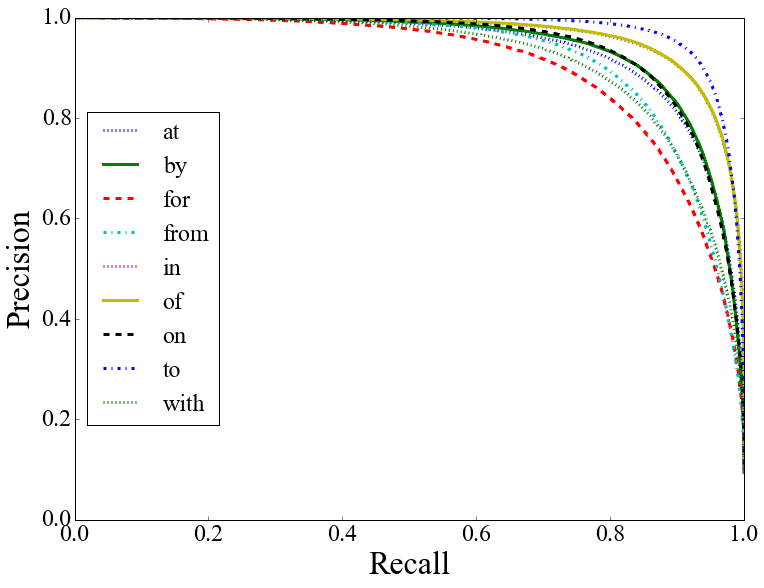

In [31]:
# Limit the scope of the variables in this cell by encapsulating them
# in a function.  Otherwise, their scope is that of the entire notebook,
# which makes variable names do more work than they ought to.  (This is
# so because in Python 2.7, variables declared inside loops are automatically
# promoted to their outer enclosing environment; I think this is no longer
# the case in Python 3 [so upgrade]).
def per_class_precision_recall_curves():
    #plt.figure(figsize=(9,6))
    
    all_prec = []
    all_rec = []
    all_prep = []
    
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    
    label_props = {'size': 32 }
    legend_props = ticks_props = { 'size': 24 }
    
    plt.setp(ax.get_xticklabels(), fontsize=legend_props['size'])
    plt.setp(ax.get_yticklabels(), fontsize=legend_props['size'])
    
    for code, preposition in enumerate(target_data['original_word_code']['names']):
        # Convert the targets to 0-1 for this preposition.
        targets_binary = model_data.target.copy()
        mask = targets_binary == code
        targets_binary[mask] = 1
        targets_binary[~mask] = 0

        # Convert the n-way softmax to a binary classification probability by taking
        # the column from the softmax that corresponds to this preposition.
        probs_binary = probs[:, code]

        prec, rec, _ = precision_recall_curve(
            targets_binary, probs_binary)
        ax.plot(rec, prec, label=preposition, ls=next(linestyle), linewidth=3)
        
        all_prec.extend(prec)
        all_rec.extend(rec)
        all_prep.extend([preposition] * len(prec))

    ax.set_xlabel('Recall', **label_props)
    ax.set_ylabel('Precision', **label_props)
    ax.legend(loc='center left', prop=legend_props)
    plt.savefig('figures/precision-recall.pdf')
    
    return pd.DataFrame({
            'Precision': all_prec,
            'Recall': all_rec,
            'Preposition': all_prep
            })
    
precision_recall_df = per_class_precision_recall_curves()

Improving detection and correction performance
==============
There are three ways improve detection and correction.  Only allow the model to make a correction if:
1. the sentence is a good length (neither too long nor too short -- 8-18 words?)
1. the sentence contains no or very few unknown words.
1. the probability of the most probable class is high.

In [32]:
def compute_n_unknown_words():
    n_unknown_words = np.zeros_like(model_data.len)
    for i in np.arange(0, len(model_data.len)):
        n_unknown_words[i] = len(np.where(model_data.data[i, 0:model_data.len[i]] == 0)[0])
    return n_unknown_words

def sentence_length_constraint(min_len=8, max_len=20):
    return (model_data.len > 8) & (model_data.len < 20)

def number_of_unknown_words_constraint(n_unknown=0):
    n_unknown_words = compute_n_unknown_words()
    return n_unknown_words <= n_unknown
    
def performance_with_constraints():
    right_length = sentence_length_constraint()
    no_unknown_words = number_of_unknown_words_constraint()
    both_constraints = right_length & no_unknown_words
    
    p, r, f, s = precision_recall_fscore_support(
            model_data.target[right_length], 
            preds[right_length],
            average=weighting)
    fbeta_05 = fbeta_score(
            model_data.target[right_length],
            preds[right_length],
            beta=0.5, average=weighting)
    print('Error correction performance with sentence length constraint')
    print(p, r, f, fbeta_05, sum(right_length))
    
    p, r, f, s = precision_recall_fscore_support(
            model_data.target[no_unknown_words], 
            preds[no_unknown_words],
            average=weighting)
    fbeta_05 = fbeta_score(
            model_data.target[no_unknown_words],
            preds[no_unknown_words],
            beta=0.5, average=weighting)
    print('Error correction performance with no unknown words constraint')
    print(p, r, f, fbeta_05, sum(no_unknown_words))
    
    p, r, f, s = precision_recall_fscore_support(
            model_data.target[both_constraints], 
            preds[both_constraints],
            average=weighting)
    fbeta_05 = fbeta_score(
            model_data.target[both_constraints],
            preds[both_constraints],
            beta=0.5, average=weighting)
    print('Error correction performance with length and unknown words constraints')
    print(p, r, f, fbeta_05, sum(both_constraints))
    
    
performance_with_constraints()

Error correction performance with sentence length constraint
(0.87368416895761958, 0.86806065971646995, 0.87063704913840523, 0.87240802476324519, 382514)
Error correction performance with no unknown words constraint
(0.86845577282758557, 0.86802154412840205, 0.86808834495917775, 0.86827303529421529, 533382)
Error correction performance with length and unknown words constraints
(0.87422727496826669, 0.87146442044039374, 0.87265895974330654, 0.87355474437826641, 232520)


Effect of length on model performance
=======

For this particular convolutional network, performance degrades with length.  I should run these reports with and without sentences that contain unknown words, in order to control for that variable.

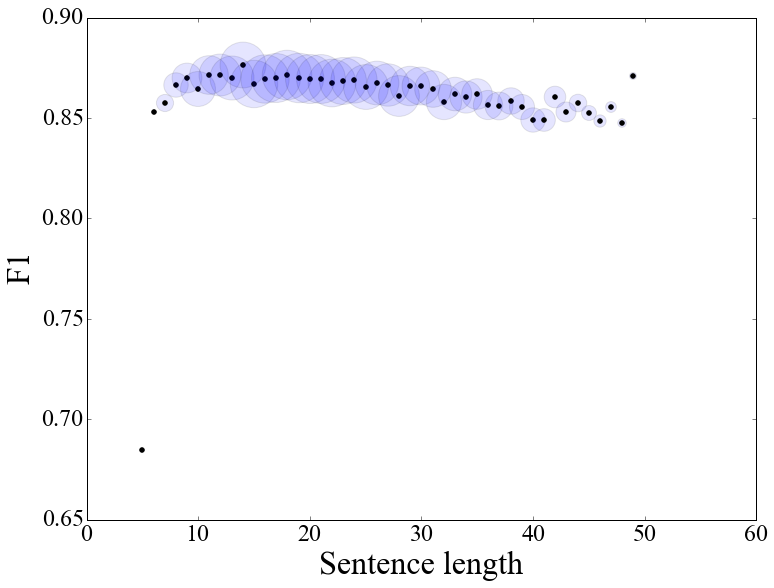

In [60]:
def plot_performance_by_length():
    f1_by_length = []
    
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    
    label_props = {'size': 32 }
    legend_props = { 'size': 24 }
    
    plt.setp(ax.get_xticklabels(), fontsize=legend_props['size'])
    plt.setp(ax.get_yticklabels(), fontsize=legend_props['size'])

    for start in np.arange(5, 50):
        end = start + 1
        idx = np.where((model_data.len >= start) & (model_data.len < end))[0]
        p, r, f, s = precision_recall_fscore_support(
                model_data.target[idx],
                preds[idx],
                average=weighting)
        #f1_by_length.append(f)
        ax.scatter(start, f, s=len(idx)/18., alpha=.1)
        ax.scatter(start, f, c='black')
        #print("{start:02d}-{end:02d} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
        #        start=start, end=end, precision=p, recall=r, f=f, support=len(idx)))
    
    ax.set_xlabel('Sentence length', **label_props)
    ax.set_ylabel('F1', **label_props)

    plt.savefig('figures/f1-by-length.pdf')
    
plot_performance_by_length()

Error detection performance conditioned on original (correct) preposition (i.e. the target variable)
========
"For" is the preposition with the lowest precision, recall, F-1, and F-0.5.

In [34]:
for code, word in enumerate(target_data['original_word_code']['names']):
    targets_with_code_idx = np.where(model_data.target == code)[0]
    error_detection_targets_word = error_detection_targets[targets_with_code_idx]
    error_detection_preds_word = (
        preds[targets_with_code_idx] != model_data.current_word_code[targets_with_code_idx]
    ).astype(int)

    p, r, f, s = precision_recall_fscore_support(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary')
    
    fbeta_05 = fbeta_score(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary',
            beta=0.5)
    
    df_row = pd.DataFrame({
                'code': [code],
                'word': [word],
                'precision': [p],
                'recall': [r],
                'f1': [f],
                'fbeta_05': [fbeta_05],
                'n': [len(targets_with_code_idx)]
            })
    
    print("{code} {word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
            code=code, word=word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=len(targets_with_code_idx)))

0 at    0.93 0.92 0.92 0.93  94994
1 by    0.93 0.93 0.93 0.93  94946
2 for   0.91 0.89 0.90 0.91  97386
3 from  0.91 0.91 0.91 0.91  90432
4 in    0.96 0.94 0.95 0.96 194416
5 of    0.96 0.94 0.95 0.96 112102
6 on    0.94 0.92 0.93 0.93 108748
7 to    0.95 0.95 0.95 0.95 113168
8 with  0.93 0.91 0.92 0.93  93360


Error detection performance conditioned on actual (possibly incorrect) preposition
=======
We would like to measure the difficulty of detecting an error given the actual preposition.  The prepositions with the lowest precision, recall, and F1, and F-0.5 are "for", "in", "in", and "for", respectively.

In [35]:
for code, word in enumerate(target_data['current_word_code']['names']):
    targets_with_code_idx = np.where(model_data.current_word_code == code)[0]
    error_detection_targets_word = error_detection_targets[targets_with_code_idx]
    error_detection_preds_word = (preds[targets_with_code_idx] != model_data.current_word_code[targets_with_code_idx]).astype(int)

    p, r, f, s = precision_recall_fscore_support(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary')
    fbeta_05 = fbeta_score(
            error_detection_targets_word,
            error_detection_preds_word,
            beta=0.5,
            average='binary')
    print("{code} {word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
            code=code, word=word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=len(targets_with_code_idx)))

0 at    0.94 0.94 0.94 0.94 104427
1 by    0.95 0.94 0.94 0.94 104302
2 for   0.92 0.90 0.91 0.92 105280
3 from  0.93 0.93 0.93 0.93 102136
4 in    0.93 0.89 0.91 0.92 147515
5 of    0.96 0.95 0.95 0.96 111415
6 on    0.94 0.92 0.93 0.93 109835
7 to    0.95 0.96 0.96 0.96 111686
8 with  0.94 0.91 0.92 0.93 102956


Error correction performance conditioned on original preposition
--------

In [36]:
word = target_data['current_word_code']['names']
codes = np.arange(len(word))
p, r, f, s = precision_recall_fscore_support(
        model_data.target,
        preds,
        average=None)
fbeta_05 = fbeta_score(
        model_data.target,
        preds,
        beta=0.5,
        average=None)
df_correction = pd.DataFrame({
        'word': word,
        'precision': p,
        'recall': r,
        'f1': f,
        'fbeta_05': fbeta_05,
        'n': s
        })
df_correction = df_correction[['word', 'precision', 'recall', 'f1', 'n']]
print(df_correction.to_latex(index=False, float_format=lambda f: '%.02f' % f))

\begin{tabular}{lrrrr}
\toprule
 word &  precision &  recall &   f1 &       n \\
\midrule
   at &       0.88 &    0.85 & 0.86 &   94994 \\
   by &       0.87 &    0.87 & 0.87 &   94946 \\
  for &       0.83 &    0.80 & 0.82 &   97386 \\
 from &       0.86 &    0.83 & 0.84 &   90432 \\
   in &       0.89 &    0.91 & 0.90 &  194416 \\
   of &       0.89 &    0.91 & 0.90 &  112102 \\
   on &       0.87 &    0.87 & 0.87 &  108748 \\
   to &       0.94 &    0.91 & 0.92 &  113168 \\
 with &       0.81 &    0.85 & 0.83 &   93360 \\
\bottomrule
\end{tabular}



Error correction performance conditioned on actual (possibly incorrect) preposition and original (correct) preposition
========

In [37]:
def error_correction_performance_conditioned_on_actual_and_original():
    correction_conditioned_actual_orig = []

    n_error_correction = (error_detection_preds == 1).sum()

    for current_word_code, current_word in enumerate(target_data['current_word_code']['names']):
        # Error correction performance is only computed over the examples for which
        # the model's predicted preposition differs from the actual preposition.

        # First find the examples for which the model's predicted preposition differs from
        # the actual preposition.
        error_correction_mask = error_detection_preds == 1

        # Then find the examples that have the given original preposition.
        targets_with_code = model_data.current_word_code == current_word_code

        targets_with_code_idx = np.where(error_correction_mask & targets_with_code)[0]
        error_correction_targets_word = model_data.target[targets_with_code_idx]
        error_correction_preds_word = preds[targets_with_code_idx]

        error_correction_targets_word = error_correction_targets_word
        error_correction_preds_word = error_correction_preds_word

        p, r, f, s = precision_recall_fscore_support(
                error_correction_targets_word,
                error_correction_preds_word,
                average=None)

        for original_word_code, original_word in enumerate(target_data['original_word_code']['names']):
            f1_macro = f[original_word_code] * s[original_word_code] / n_error_correction
            correction_conditioned_actual_orig.append({
                    'current_word': current_word,
                    'original_word': original_word,
                    'precision': p[original_word_code],
                    'recall': r[original_word_code],
                    'f1': f[original_word_code],
                    'f1macro': f1_macro,
                    'n': s[original_word_code]
                })

    df = pd.DataFrame(correction_conditioned_actual_orig)
    df = df.sort(['f1'])
    df = df[['current_word', 'original_word', 'precision', 'recall', 'f1', 'f1macro', 'n']]
    pd.set_option('display.precision', 3)

    print('The 20 most difficult current-original word pairs\n')
    print(df[df.precision > 0].head(n=20))
    print('')

    print('The 20 easiest current-original word pairs\n')
    print(df[df.precision > 0].tail(n=20))
    print('')

    print(df[df.precision > 0].f1macro.sum())
    
#error_correction_performance_conditioned_on_actual_and_original()

In [38]:
df_sizes = pd.DataFrame({
        'preposition': target_data['original_word_code']['names'],
        'n': np.bincount(model_data.target)
        })
df_sizes[['preposition', 'n']]

,preposition,n
0,at,94994
1,by,94946
2,for,97386
3,from,90432
4,in,194416
5,of,112102
6,on,108748
7,to,113168
8,with,93360


Correlation of number of examples and performance
===========
The distribution of errors in the validation set is proportional to that of the training set.  The figures and tables below explore the relationship between the number of training examples and the performance on each kind of example.

In [39]:
def plot_performance_by_number_of_examples():
    plt.figure(figsize=(15,8))
    cols = ['red', 'blue', 'green', 'magenta', 'yellow', 'pink', 'cyan', 'brown', 'gray', 'black']
    for i, original_word in enumerate(target_data['original_word_code']['names']):
        df_original_word = df[(df.f1 > 0) & (df.original_word == original_word)]
        plt.scatter(df_original_word.n, df_original_word.f1, c=cols[i], label=original_word, s=40)
    plt.legend(loc='lower right')
#plot_performance_by_number_of_examples()

In [40]:
def plot_performance_by_number_of_examples_without_in():
    df_without_in = df[df.original_word != 'in']
    print(np.corrcoef(df_without_in[df_without_in.f1 > 0].n, df_without_in[df_without_in.f1 > 0].f1))
    plt.figure(figsize=(12,9))
    cols = ['red', 'blue', 'green', 'magenta', 'yellow', 'pink', 'cyan', 'brown', 'gray', 'black']
    for i, original_word in enumerate(target_data['original_word_code']['names']):
        if original_word == 'in':
            continue
        df_original_word = df_without_in[(df_without_in.f1 > 0) & (df_without_in.original_word == original_word)]
        plt.scatter(df_original_word.n, df_original_word.f1, c=cols[i], label=original_word, s=40)
    plt.legend(loc='lower right')
#plot_performance_by_number_of_examples_without_in()

Sizes of things
========

In [41]:
train_size = 59972006
validation_size = 999532
test_size = 999552

In [42]:
def sizes():
    df_sizes = pd.DataFrame({
        'preposition': target_data['original_word_code']['names'],
        'n': np.bincount(model_data.target)
        })
    df = df_sizes[['preposition', 'n']]
    print(df)
    print(df.to_latex(index=False))
sizes()

  preposition       n
0          at   94994
1          by   94946
2         for   97386
3        from   90432
4          in  194416
5          of  112102
6          on  108748
7          to  113168
8        with   93360
\begin{tabular}{lr}
\toprule
preposition &       n \\
\midrule
         at &   94994 \\
         by &   94946 \\
        for &   97386 \\
       from &   90432 \\
         in &  194416 \\
         of &  112102 \\
         on &  108748 \\
         to &  113168 \\
       with &   93360 \\
\bottomrule
\end{tabular}



In [43]:
google_n_gram_pcts = np.array([.3015, .4219, .6588, .3345, 1.559, 2.939, .4719, 1.976, .516])
normalized_google_n_gram_pcts = google_n_gram_pcts / google_n_gram_pcts.sum()
print(normalized_google_n_gram_pcts)

[ 0.033  0.046  0.072  0.036  0.17   0.32   0.051  0.215  0.056]


In [44]:
#df_convnet = pd.read_csv('models/keras/preposition/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/val_acc.csv')
#df_lstm = pd.read_csv('models/keras/preposition/lstm/b7fb442a677b11e59dd822000a4389ba/val_acc.csv')

In [45]:
# plt.figure(figsize=(15,12))
# plt.scatter(range(1, len(df_convnet)+1), df_convnet.ix[:, 0], alpha=0.75, label='ConvNet', c='red')
# plt.scatter(range(1, len(df_lstm)+1), df_lstm.ix[:, 0], alpha=0.75, label='LSTM', c='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.xlim(0, max(len(df_convnet), len(df_lstm))+1)
# plt.legend()

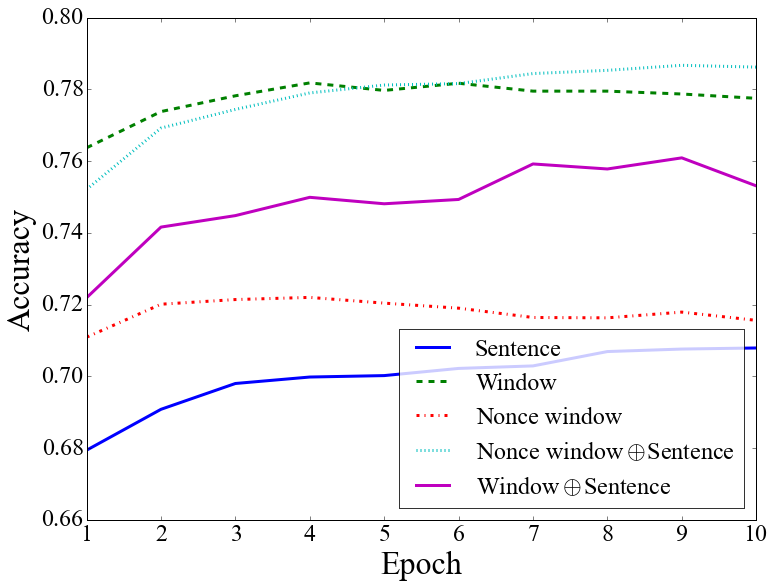

In [46]:
def plot_feature_comparison():
    feature_comparison_csv = os.environ['HOME'] + '/proj/dissertation/projects/cnn/data/preposition/figures/preposition-feature-comparison.csv'
    feature_comparison_df = pd.read_csv(feature_comparison_csv, sep='\t')
    
    plt.figure(figsize=(12,9))
    ax = plt.subplot(111)
    
    label_props = {'size': 32 }
    legend_props = { 'size': 24 }
    
    plt.setp(ax.get_xticklabels(), fontsize=legend_props['size'])
    plt.setp(ax.get_yticklabels(), fontsize=legend_props['size'])
    
    def rename_nonce(s):
        return s
        if s == 'Nonce window':
            return 'Nonce'
        return s
    
    for features in feature_comparison_df.Features.unique():
        if '+' in features:
            fields = features.split('+')
            fields[0] = rename_nonce(fields[0])
            label = fields[0] + r'$\oplus$' + fields[1]
        else:
            label = rename_nonce(features)
        df_features = feature_comparison_df[feature_comparison_df.Features == features]
        ax.plot(df_features.Epoch, df_features.ValAcc, label=label, ls=next(linestyle), linewidth=3)
    
    ax.set_xlabel('Epoch', **label_props)
    ax.set_ylabel('Accuracy', **label_props)
    leg = ax.legend(loc='lower right', prop=legend_props)
    leg.get_frame().set_alpha(0.8)
    plt.savefig('figures/preposition-feature-comparison-valid.pdf')
    
plot_feature_comparison()